In [47]:
root_directory= r'C:\Users\Usuario\OneDrive\Escritorio\368'

## Extraer archivos desde carpeta

In [2]:
keyword_EB = "EB"
keyword_IB4= "IB4"
keyword_iba1= "IBA1"

1. Asegurarse de que en root directory está la carpeta de la muestra que queremos
2. Modificar keyword ("if filename.endswith('csv') and *keyword_iba1* in filename"), la función va a seleccionar todos los archivos que tengan el keyword en su titulo, asegurarse de que el archivo solo tenga el nombre de un marcaje
3. cada vez que se ejecute la funcion la lista de dataframes se va a reiniciar, por lo que hay que pasar al siguiente paso.

In [54]:
import pandas as pd
import os

dataframes = []

for subdir, dirs, files in os.walk(root_directory):
    for filename in files:
        if filename.endswith('csv') and keyword_iba1 in filename:
            filepath = os.path.join(subdir, filename)
            print(f"Procesando archivo: {filepath}")  # Agregar declaración de impresión
            try:
                # Leer cada archivo CSV y añadirlo a la lista de dataframes
                df = pd.read_csv(filepath, encoding='latin1', skiprows=3, on_bad_lines='skip')
                #Limpiar DF
                df = df[~df.astype(str).apply(lambda x: x.str.contains('=')).any(axis=1)]
                print(df.head())
                dataframes.append(df)
            except Exception as e:
                print(f"Error al procesar el archivo {filepath}: {e}")

Procesando archivo: C:\Users\Usuario\OneDrive\Escritorio\368\1\368 APP PLX  2 b 0_5 IBA1 25x xyz_Statistics\368 APP PLX  2 b 0_5 IBA1 25x xyz_Detailed.csv
       Area   Unit Category  Time   ID  Unnamed: 5
0   135.413  Âµm^2  Surface     1  124         NaN
1   147.725  Âµm^2  Surface     1  133         NaN
2  1106.870  Âµm^2  Surface     1  170         NaN
3  3853.970  Âµm^2  Surface     1  173         NaN
4  1327.030  Âµm^2  Surface     1  183         NaN
Procesando archivo: C:\Users\Usuario\OneDrive\Escritorio\368\10\1\368 APP PLX 8 b 0_5  IBA1 25x xyz_Statistics\368 APP PLX 8 b 0_5  IBA1 25x xyz_Detailed.csv
       Area   Unit Category  Time  ID  Unnamed: 5
0   4.88323  Âµm^2  Surface     1  28         NaN
1  11.62560  Âµm^2  Surface     1  29         NaN
2   6.13932  Âµm^2  Surface     1  30         NaN
3  70.04490  Âµm^2  Surface     1  31         NaN
4  29.94590  Âµm^2  Surface     1  32         NaN
Procesando archivo: C:\Users\Usuario\OneDrive\Escritorio\368\10\2\368 APP PLX 8 b

La función individualizar agrupa la lista de excels que han salido de la función anterior y los agrupa, generando un solo excel en el que cada fila es el valor de un marcaje para una placa.

En sample_type poner el tipo de marcaje

In [55]:
sample_type = "IBA1"

In [6]:
def Individualizar (dataframes_lista, sample_type):
    area_total_individual_lista = []
    for df in dataframes_lista:
        area_total_individual = df['Area'].sum()
        area_total_individual_lista.append(pd.DataFrame({f'Area_Total_{sample_type}' : [area_total_individual] }))

    
    return pd.concat(area_total_individual_lista, ignore_index=True)
    

In [ ]:
#Como usar:

#Nombre de mi dataframe# = Individualizar (#dataframes, sample_type)

In [56]:
IBA1_368 = Individualizar(dataframes, sample_type)

# Combinar DF

Combina un DF de IB4 y otro de iba1, idealmente de la misma muestra, genera un nuevo df con ambas columnas y otra que saca la relación IB4/IBA1

*Vigilar que siempre en el primer df sea IB4, y el segundo IBA1, si no hará la división al revés*

In [17]:
def create_combined_df(df1, df2, sample_number):
    # Combinar los dos DataFrames
    combined_df = pd.concat([df1, df2], axis=1)

    
    
    # Renombrar columnas para evitar conflictos
    combined_df.columns = [f'{col}_{sample_number}' for col in df1.columns] + [f'{col}_{sample_number}' for col in df2.columns]
    
    # Crear la columna IB4/IBA1[Nºmuestra]
    combined_df[f'IB4/IBA1_{sample_number}'] = combined_df.iloc[:, 0] / combined_df.iloc[:, len(df1.columns)]
    
    # Renombrar el DataFrame
    combined_df.name = f'PRUEBA_{sample_number}'
    
    return combined_df

In [ ]:
IB4_IBA1_354 = create_combined_df(IB4_354, IBA1_354, 354)

In [59]:
IB4_IBA1_368 = create_combined_df(IB4_368, IBA1_368, 368)

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def Correlation(df, column_1, column_2, nombre):
    # Calcular la correlación (coeficiente de correlación de Pearson)
    correlation = df.iloc[:, column_1].corr(df.iloc[:, column_2])
    print(f'Correlación entre {df.columns[column_1]} y {df.columns[column_2]}: {correlation}')

    # Calcular el coeficiente de determinación R^2
    x = df.iloc[:, column_1].values.reshape(-1, 1)
    y = df.iloc[:, column_2].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    r2 = r2_score(y, y_pred)
    print(f'R^2: {r2}')

    # Obtener los coeficientes de la recta
    intercept = model.intercept_[0]
    slope = model.coef_[0][0]

    # Crear el gráfico de dispersión con una línea de regresión
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df.iloc[:, column_1], y=df.iloc[:, column_2], s=50, alpha=1)
    sns.lineplot(x=df.iloc[:, column_1], y=y_pred.flatten(), color='red')

    # Anotar el R^2, r y la ecuación de la recta en el gráfico
    plt.text(0.05, 0.95, f'$r = {correlation:.3f}$\n$R^2 = {r2:.3f}$\n$y = {slope:.3f}x + {intercept:.3f}$',
             transform=plt.gca().transAxes, fontsize=17, verticalalignment='top')

    plt.tick_params(axis='both', which='major', labelsize=20)


    # Título del gráfico
    plt.title(nombre)
    
    # Mostrar el gráfico
    plt.show()

Correlación entre Area_Total_IBA1_368 y Area_Total_IB4_368: 0.7409662779202045
R^2: 0.5490310250149218


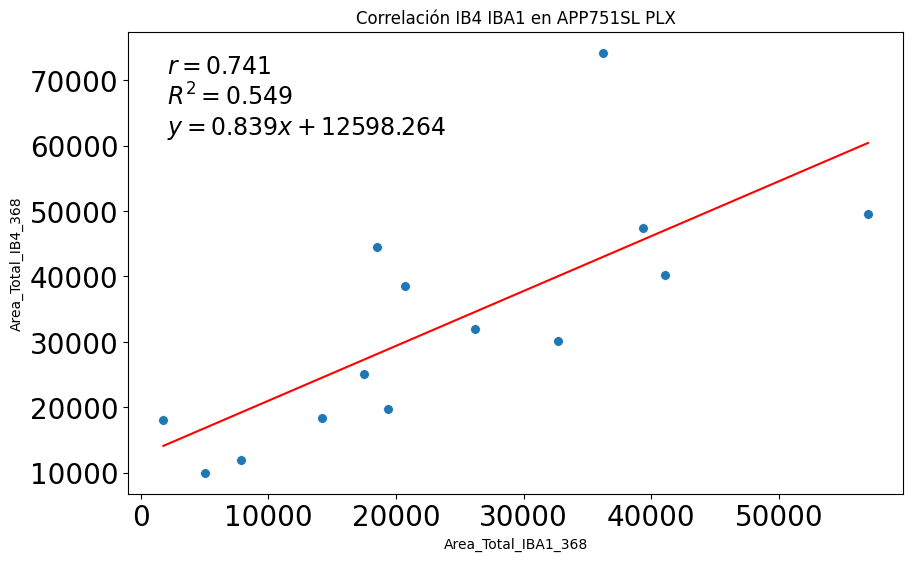

In [95]:
Correlation(IB4_IBA1_368, 1, 0, "Correlación IB4 IBA1 en APP751SL PLX" )

# Combinar columnas y hacer test estadísticos

La función compara columnas de dos dataframes distintos (de muestras distintas), realiza el shapiro para normalidad, si ambas son normales hace t-test y si no Mann-Whitney, p-valor <0.05

Si por ejemplo quiero comparar carga de IB4 en mis dos muestras, suponiendo que tengo IB4 en la columna 1 de ambos df:

combine_columns_and_test (df_muestracontrol, df_muestraPLX, 1)

In [84]:
import pandas as pd
from scipy import stats



def combine_columns_and_test(df1, df2, col_number):
    # Combinar la columna 3 de los dos DataFrames, conservando los nombres de las columnas originales
    combined_df = pd.concat([df1.iloc[:, col_number], df2.iloc[:, col_number]], axis=1)
    combined_df = combined_df.dropna()
    print(combined_df.head())

    combined_df.columns = [df1.columns[col_number], df2.columns[col_number]]

    # Realizar el test de Shapiro-Wilk para normalidad
    shapiro_results = {}
    for col in combined_df.columns:
        stat, p_value = stats.shapiro(combined_df[col])
        shapiro_results[col] = {
            'statistic': stat,
            'p_value': p_value,
            'is_normal': p_value > 0.05
        }
    print(shapiro_results)
    # Mostrar resultados del test de Shapiro-Wilk
    for col, result in shapiro_results.items():
        print(f"Shapiro-Wilk test for {col}:")
        print(f"  Statistic: {result['statistic']}")
        print(f"  P-value: {result['p_value']}")
        print(f"  Is normal: {result['is_normal']}")

    # Realizar el test t de Student o el test de Mann-Whitney
    if all(result['is_normal'] for result in shapiro_results.values()):
        test_name = 'T-test'
        stat, p_value = stats.ttest_ind(combined_df.iloc[:, 0], combined_df.iloc[:, 1])
    else:
        test_name = 'Mann-Whitney U test'
        stat, p_value = stats.mannwhitneyu(combined_df.iloc[:, 0], combined_df.iloc[:, 1], method="exact")
    
    # Mostrar resultados del test de comparación
    print(f"\n{test_name}:")
    print(f"  Statistic: {stat}")
    print(f"  P-value: {p_value}")
    print(f"  Is there a significant difference: {p_value < 0.05}")

In [86]:
combine_columns_and_test(IB4_IBA1_368, IB4_IBA1_354, 1)

   Area_Total_IBA1_368  Area_Total_IBA1_354
0         19385.752000         47870.643421
1          5010.255235         22238.172287
2         26169.903020          7215.625330
3         56962.181000         29435.456205
4         41045.452000         44856.899036
{'Area_Total_IBA1_368': {'statistic': 0.9621504545211792, 'p_value': 0.7583035230636597, 'is_normal': True}, 'Area_Total_IBA1_354': {'statistic': 0.7073798179626465, 'p_value': 0.00044102015090174973, 'is_normal': False}}
Shapiro-Wilk test for Area_Total_IBA1_368:
  Statistic: 0.9621504545211792
  P-value: 0.7583035230636597
  Is normal: True
Shapiro-Wilk test for Area_Total_IBA1_354:
  Statistic: 0.7073798179626465
  P-value: 0.00044102015090174973
  Is normal: False

Mann-Whitney U test:
  Statistic: 67.0
  P-value: 0.16355239476924766
  Is there a significant difference: False
